In [2]:
!pip install pycausalimpact

In [3]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima_process import ArmaProcess
from causalimpact import CausalImpact

In [4]:
from pyhive import presto

def get_presto_conn():
    return presto.connect(host='presto-alpha-backend.data.houzz.net', port=8086)

def presto_query(query, presto_conn, fetchall=True):
    cursor = presto_conn.cursor()
    cursor.execute(query)
    header = list(map(operator.itemgetter(0), cursor.description))
    return header, cursor.fetchall()
conn = get_presto_conn() 

In [68]:
%%time
# import daily gmv, spend, cm for each leaf category in direct from 2020
ts = pd.read_sql("""
                select dt, ramp, 
                            l1, l2, l3, l4, 
                            a.leaf_category, 
                            sum(gmv_w_cancel_est) gmv_w_cancel_est,
                            sum(spend) spend,
                            sum(cm) cm
                from mp.order_item_cm_metrics a
                left join wandajuan.llcm_leaf_split b 
                on a.leaf_category = b.leaf_category 
                where dt >= '2020-01-01'
                and dt != '2021-11-12'
                and seller_type = 'Direct'
                group by 1, 2, 3, 4, 5, 6, 7
                """, conn)
ts.head()

CPU times: user 3.59 s, sys: 369 ms, total: 3.96 s
Wall time: 2min


,dt,ramp,l1,l2,l3,l4,leaf_category,gmv_w_cancel_est,spend,cm
0,2020-01-28,T2,home improvement,hardware,door hardware,doorbells and chimes,doorbells and chimes,0.00,0.000000,0.705000
1,2020-02-07,T2,furniture,bedroom furniture,headboards,Unmapped,headboards,1799.07,-83.337656,377.951966
2,2020-05-16,T1,home improvement,hardware,door hardware,door locks,door locks,32.02,-2.874025,6.745349
3,2021-10-09,C2,lighting,wall lighting,wall sconces,Unmapped,wall sconces,1634.00,-476.330335,59.064890
4,2020-02-17,None,outdoor products,gardening and lawn care,outdoor pots and planters,Unmapped,outdoor pots and planters,6586.34,-331.301923,883.128683


In [77]:
ts['dt'] = pd.to_datetime(ts['dt'])
ts['year'] = ts['dt'].dt.year
ts['month'] = ts['dt'].dt.to_period('M').dt.to_timestamp()
ts['week'] = ts['dt'].dt.to_period('W')
ts['week_start'] = ts['dt'].dt.to_period('W').apply(lambda r: r.start_time)
ts.head()

,dt,ramp,l1,l2,l3,l4,leaf_category,gmv_w_cancel_est,spend,cm,year,month,week,week_start
0,2020-01-28,T2,home improvement,hardware,door hardware,doorbells and chimes,doorbells and chimes,0.00,0.000000,0.705000,2020,2020-01-01,2020-01-27/2020-02-02,2020-01-27
1,2020-02-07,T2,furniture,bedroom furniture,headboards,Unmapped,headboards,1799.07,-83.337656,377.951966,2020,2020-02-01,2020-02-03/2020-02-09,2020-02-03
2,2020-05-16,T1,home improvement,hardware,door hardware,door locks,door locks,32.02,-2.874025,6.745349,2020,2020-05-01,2020-05-11/2020-05-17,2020-05-11
3,2021-10-09,C2,lighting,wall lighting,wall sconces,Unmapped,wall sconces,1634.00,-476.330335,59.064890,2021,2021-10-01,2021-10-04/2021-10-10,2021-10-04
4,2020-02-17,None,outdoor products,gardening and lawn care,outdoor pots and planters,Unmapped,outdoor pots and planters,6586.34,-331.301923,883.128683,2020,2020-02-01,2020-02-17/2020-02-23,2020-02-17


# T1

In [58]:
# filter for non-null and non-dining tables
ts_T1 = ts.query('ramp == ramp and leaf_category != "dining tables"') 
ts_T1 = ts_T1.assign(T1 = np.where(ts_T1['ramp']=='T1', 'T1', 'Other'))
ts_T1

,dt,ramp,leaf_category,gmv_w_cancel_est,spend,cm,year,month,week,week_start,T1
0,2020-06-19,T1,wall organizers,0.00,-3.670000,-3.388000,2020,2020-06-01,2020-06-15/2020-06-21,2020-06-15,T1
1,2020-06-27,T1,decorative objects and figurines,1210.04,-76.533111,-30.284061,2020,2020-06-01,2020-06-22/2020-06-28,2020-06-22,T1
2,2020-07-02,C2,darts and dartboards,0.00,-5.800000,-5.800000,2020,2020-07-01,2020-06-29/2020-07-05,2020-06-29,Other
3,2020-07-04,C2,wall mirrors,4890.02,-150.744804,704.743306,2020,2020-07-01,2020-06-29/2020-07-05,2020-06-29,Other
5,2020-07-25,T2,seat cushions,1316.41,-97.723197,171.756963,2020,2020-07-01,2020-07-20/2020-07-26,2020-07-20,Other
...,...,...,...,...,...,...,...,...,...,...,...
442858,2021-05-09,C2,can openers,0.00,-0.140000,-0.140000,2021,2021-05-01,2021-05-03/2021-05-09,2021-05-03,Other
442859,2020-01-07,T2,specialty kitchen tools,0.00,-0.170000,-0.170000,2020,2020-01-01,2020-01-06/2020-01-12,2020-01-06,Other
442860,2021-07-19,T2,storage and organization,0.00,-3.360000,-3.360000,2021,2021-07-01,2021-07-19/2021-07-25,2021-07-19,Other
442861,2021-10-27,C2,food mills,0.00,-0.060000,-0.060000,2021,2021-10-01,2021-10-25/2021-10-31,2021-10-25,Other


## daily GMV (significant down by 7.47%)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    93529.4            1964117.31
Prediction (s.d.)         101077.93 (2716.36)2122636.52 (57043.66)
95% CI                    [95880.37, 106528.32][2013487.74, 2237094.79]

Absolute effect (s.d.)    -7548.53 (2716.36) -158519.22 (57043.66)
95% CI                    [-12998.93, -2350.97][-272977.49, -49370.43]

Relative effect (s.d.)    -7.47% (2.69%)     -7.47% (2.69%)
95% CI                    [-12.86%, -2.33%]  [-12.86%, -2.33%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 99.6%

For more details run the command: print(impact.summary('report'))


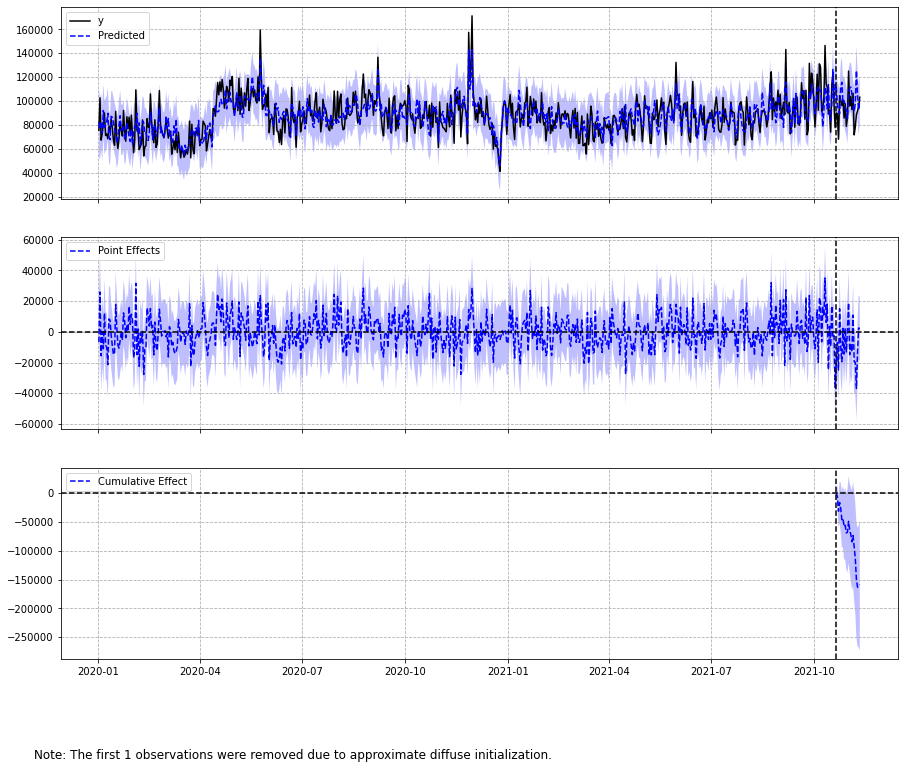

In [59]:
time_lvl = 'dt'
metric = 'gmv_w_cancel_est'

pre_period = ['2020-01-01', '2021-10-21']
post_period = ['2021-10-22', '2021-11-11']

data = ts_T1.groupby([time_lvl, 'T1'])[metric].sum().reset_index().pivot(time_lvl, 'T1', metric)
data = data[['T1', 'Other']]

ci = CausalImpact(data, pre_period, post_period)
print(ci.summary())
ci.plot()

## Daily CM (Insig. neutral)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    7828.07            164389.55
Prediction (s.d.)         7803.96 (800.17)   163883.24 (16803.64)
95% CI                    [6287.39, 9424.01] [132035.2, 197904.28]

Absolute effect (s.d.)    24.11 (800.17)     506.3 (16803.64)
95% CI                    [-1595.94, 1540.68][-33514.73, 32354.34]

Relative effect (s.d.)    0.31% (10.25%)     0.31% (10.25%)
95% CI                    [-20.45%, 19.74%]  [-20.45%, 19.74%]

Posterior tail-area probability p: 0.49
Posterior prob. of a causal effect: 50.55%

For more details run the command: print(impact.summary('report'))


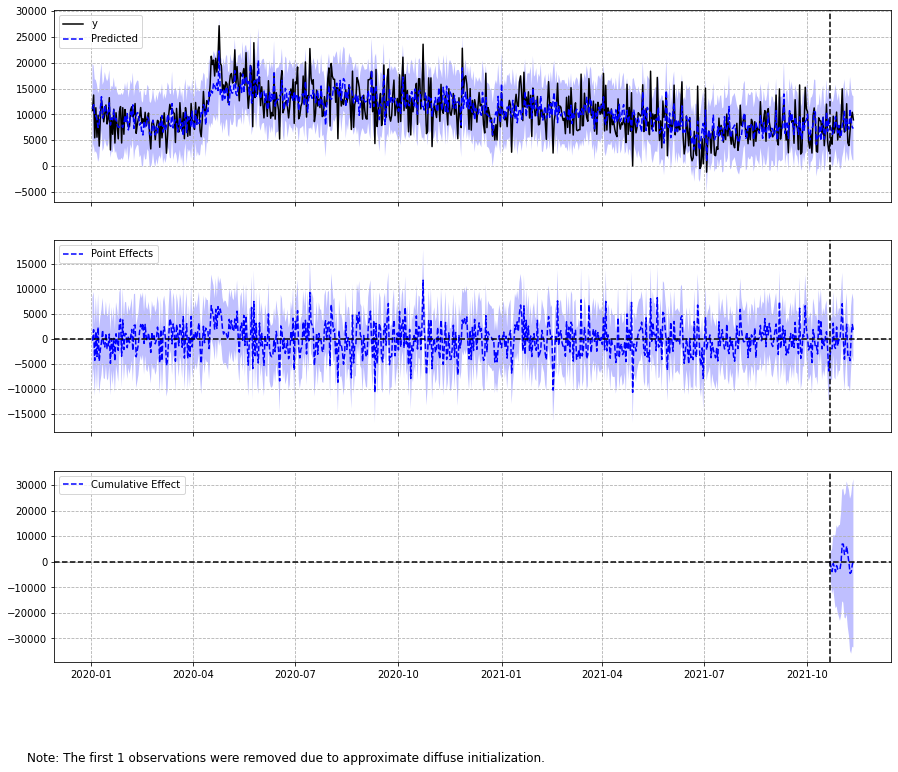

In [60]:
time_lvl = 'dt'
metric = 'cm'

pre_period = ['2020-01-01', '2021-10-21']
post_period = ['2021-10-22', '2021-11-11']

data = ts_T1.groupby([time_lvl, 'T1'])[metric].sum().reset_index().pivot(time_lvl, 'T1', metric)
data = data[['T1', 'Other']]

ci = CausalImpact(data, pre_period, post_period)
print(ci.summary())
ci.plot()

## Weekly GMV (significant down by 8%)

In [34]:
data.loc[data.index<'2021-10-22'].index.min(), \
data.loc[data.index<'2021-10-22'].index.max(), \
data.loc[data.index>='2021-10-22'].index.min(), \
data.loc[(data.index>='2021-10-22') & (data.index<='2021-11-11')].index.max()

(Timestamp('2019-12-30 00:00:00'),
 Timestamp('2021-10-18 00:00:00'),
 Timestamp('2021-10-25 00:00:00'),
 Timestamp('2021-11-08 00:00:00'))

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    631133.03          1893399.09
Prediction (s.d.)         685916.84 (17829.08)2057750.53 (53487.24)
95% CI                    [651729.16, 721617.87][1955187.49, 2164853.61]

Absolute effect (s.d.)    -54783.82 (17829.08)-164351.45 (53487.24)
95% CI                    [-90484.84, -20596.13][-271454.52, -61788.4]

Relative effect (s.d.)    -7.99% (2.6%)      -7.99% (2.6%)
95% CI                    [-13.19%, -3.0%]   [-13.19%, -3.0%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 99.7%

For more details run the command: print(impact.summary('report'))


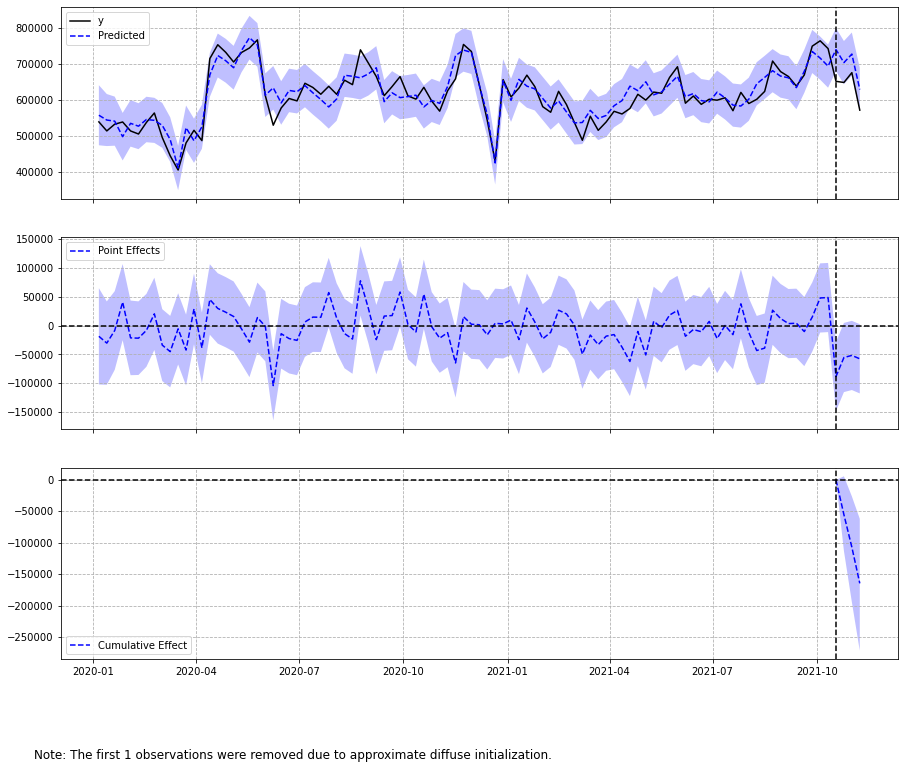

In [63]:

pre_period = ['2019-12-30', '2021-10-18']
post_period = ['2021-10-25', '2021-11-08']

time_lvl = 'week_start'
metric = 'gmv_w_cancel_est'

data = ts_T1.groupby([time_lvl, 'T1'])[metric].sum().reset_index().pivot(time_lvl, 'T1', metric)
data = data[['T1', 'Other']]

ci = CausalImpact(data, pre_period, post_period)
print(ci.summary())
ci.plot()


## Weekly CM (insig. down by 2.5%)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    52588.14           157764.41
Prediction (s.d.)         53971.13 (5012.44) 161913.38 (15037.31)
95% CI                    [43874.39, 63522.77][131623.16, 190568.32]

Absolute effect (s.d.)    -1382.99 (5012.44) -4148.97 (15037.31)
95% CI                    [-10934.64, 8713.75][-32803.91, 26141.25]

Relative effect (s.d.)    -2.56% (9.29%)     -2.56% (9.29%)
95% CI                    [-20.26%, 16.15%]  [-20.26%, 16.15%]

Posterior tail-area probability p: 0.41
Posterior prob. of a causal effect: 58.94%

For more details run the command: print(impact.summary('report'))


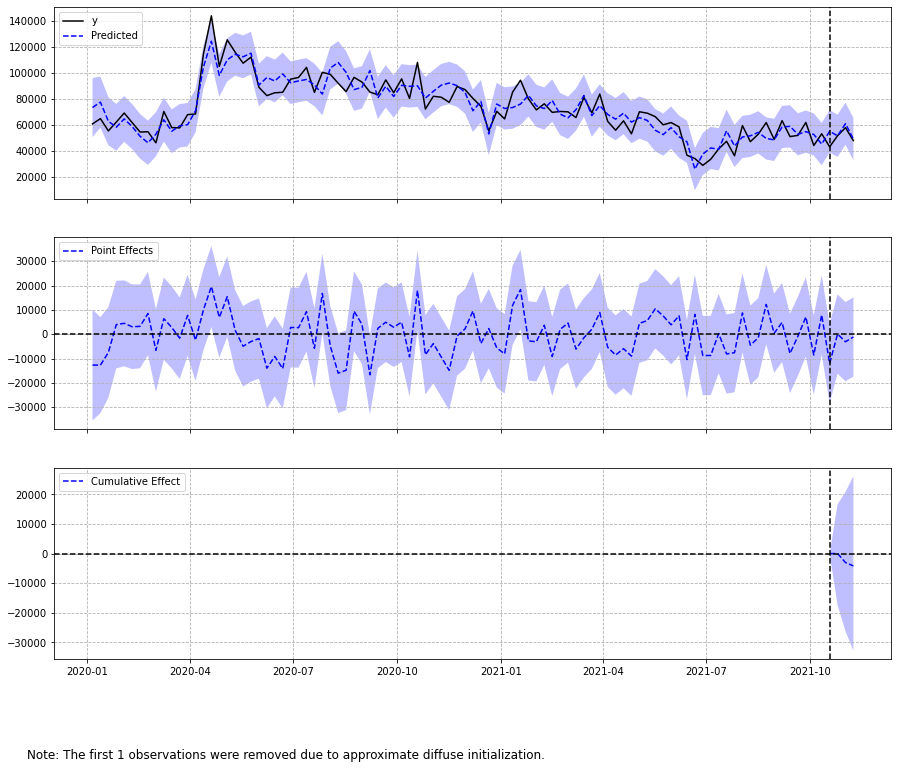

In [64]:
pre_period = ['2019-12-30', '2021-10-18']
post_period = ['2021-10-25', '2021-11-08']

time_lvl = 'week_start'
metric = 'cm'

data = ts_T1.groupby([time_lvl, 'T1'])[metric].sum().reset_index().pivot(time_lvl, 'T1', metric)
data = data[['T1', 'Other']]

ci = CausalImpact(data, pre_period, post_period)
print(ci.summary())
ci.plot()

## Monthly GMV (Insig. down by 3%)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1489243.66         2978487.32
Prediction (s.d.)         1539915.69 (56941.77)3079831.38 (113883.54)
95% CI                    [1431660.61, 1654868.25][2863321.23, 3309736.5]

Absolute effect (s.d.)    -50672.03 (56941.77)-101344.05 (113883.54)
95% CI                    [-165624.59, 57583.05][-331249.18, 115166.1]

Relative effect (s.d.)    -3.29% (3.7%)      -3.29% (3.7%)
95% CI                    [-10.76%, 3.74%]   [-10.76%, 3.74%]

Posterior tail-area probability p: 0.18
Posterior prob. of a causal effect: 82.32%

For more details run the command: print(impact.summary('report'))


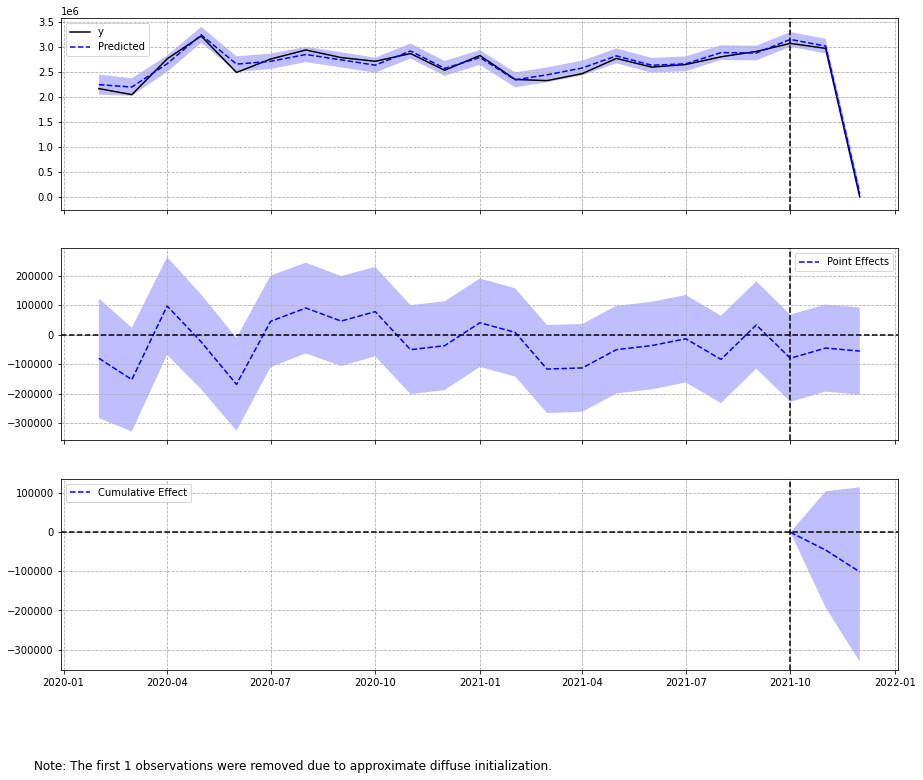

In [65]:
pre_period = ['2020-01-01', '2021-10-01']
post_period = ['2021-11-01', '2021-12-01']

time_lvl = 'month'
metric = 'gmv_w_cancel_est'

data = ts_T1.groupby([time_lvl, 'T1'])[metric].sum().reset_index().pivot(time_lvl, 'T1', metric)
data = data[['T1', 'Other']]

ci = CausalImpact(data, pre_period, post_period)
print(ci.summary())
ci.plot()

## Monthly CM (close to sign, up by 25%)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    109210.1           218420.2
Prediction (s.d.)         86857.17 (14352.7) 173714.34 (28705.4)
95% CI                    [59701.14, 115962.7][119402.29, 231925.41]

Absolute effect (s.d.)    22352.93 (14352.7) 44705.85 (28705.4)
95% CI                    [-6752.6, 49508.95][-13505.21, 99017.91]

Relative effect (s.d.)    25.74% (16.52%)    25.74% (16.52%)
95% CI                    [-7.77%, 57.0%]    [-7.77%, 57.0%]

Posterior tail-area probability p: 0.06
Posterior prob. of a causal effect: 94.01%

For more details run the command: print(impact.summary('report'))


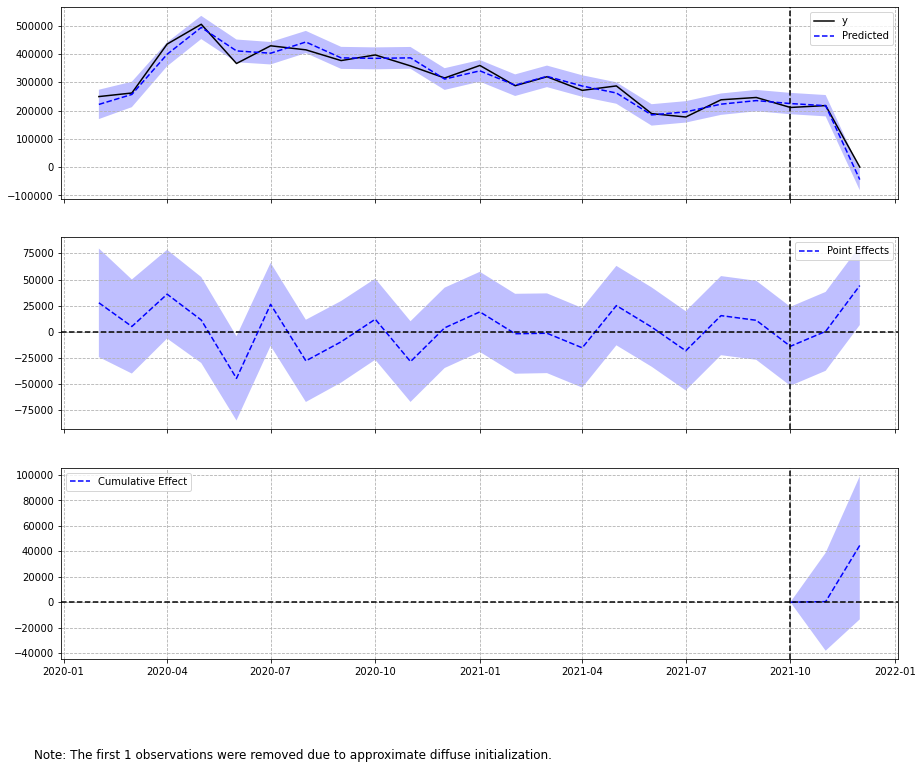

In [66]:
pre_period = ['2020-01-01', '2021-10-01']
post_period = ['2021-11-01', '2021-12-01']

time_lvl = 'month'
metric = 'cm'

data = ts_T1.groupby([time_lvl, 'T1'])[metric].sum().reset_index().pivot(time_lvl, 'T1', metric)
data = data[['T1', 'Other']]

ci = CausalImpact(data, pre_period, post_period)
print(ci.summary())
ci.plot()

# Bath Vanities

In [79]:
# filter for bath products and exclude T1
ts_bath = ts.query('l1=="bath products" and ramp != "T1"') 
ts_bath = ts_bath.assign(bath = np.where(ts_bath['leaf_category']=='bathroom vanities and sink consoles', 'vanities', 'other bath'))
ts_bath

,dt,ramp,l1,l2,l3,l4,leaf_category,gmv_w_cancel_est,spend,cm,year,month,week,week_start,bath
12,2021-10-18,T2,bath products,vanity stools and benches,Unmapped,Unmapped,vanity stools and benches,589.00,-45.155635,81.070977,2021,2021-10-01,2021-10-18/2021-10-24,2021-10-18,other bath
16,2021-03-06,C1,bath products,bathroom fixture parts,tub and shower parts,Unmapped,tub and shower parts,904.00,-24.268594,261.216094,2021,2021-03-01,2021-03-01/2021-03-07,2021-03-01,other bath
21,2020-04-26,T2,bath products,bathroom shelves,Unmapped,Unmapped,bathroom shelves,421.99,-5.254205,32.171114,2020,2020-04-01,2020-04-20/2020-04-26,2020-04-20,other bath
78,2021-07-06,C1,bath products,bathroom fixtures,bathroom faucets and showerheads,tub and shower faucet sets,tub and shower faucet sets,782.00,-165.892765,-21.510003,2021,2021-07-01,2021-07-05/2021-07-11,2021-07-05,other bath
82,2021-06-17,T2,bath products,vanity stools and benches,Unmapped,Unmapped,vanity stools and benches,0.00,-27.175206,-25.013206,2021,2021-06-01,2021-06-14/2021-06-20,2021-06-14,other bath
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458599,2020-12-27,C1,bath products,bathroom accessories,bathroom scales,Unmapped,bathroom scales,0.00,-0.680000,-0.680000,2020,2020-12-01,2020-12-21/2020-12-27,2020-12-21,other bath
458616,2020-02-18,T2,bath products,bathroom accessories,soap dishes & holders,Unmapped,soap dishes & holders,0.00,-0.560000,-0.325000,2020,2020-02-01,2020-02-17/2020-02-23,2020-02-17,other bath
458656,2020-10-29,T2,bath products,bathroom accessories,soap dishes & holders,Unmapped,soap dishes & holders,0.00,-1.340000,-1.340000,2020,2020-10-01,2020-10-26/2020-11-01,2020-10-26,other bath
458662,2021-04-07,C1,bath products,bathroom accessories,bathroom scales,Unmapped,bathroom scales,31.00,-0.230030,3.517827,2021,2021-04-01,2021-04-05/2021-04-11,2021-04-05,other bath


In [72]:
ts_bath.groupby('bath')['gmv_w_cancel_est'].sum()

bath
other bath    1.729182e+07
vanities      4.597799e+07
Name: gmv_w_cancel_est, dtype: float64

## Daily GMV (insig. down by 3.6%)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    88079.76           1849674.95
Prediction (s.d.)         91356.23 (3559.68) 1918480.93 (74753.31)
95% CI                    [84195.47, 98149.17][1768104.93, 2061132.53]

Absolute effect (s.d.)    -3276.48 (3559.68) -68805.98 (74753.31)
95% CI                    [-10069.41, 3884.29][-211457.58, 81570.03]

Relative effect (s.d.)    -3.59% (3.9%)      -3.59% (3.9%)
95% CI                    [-11.02%, 4.25%]   [-11.02%, 4.25%]

Posterior tail-area probability p: 0.18
Posterior prob. of a causal effect: 81.72%

For more details run the command: print(impact.summary('report'))


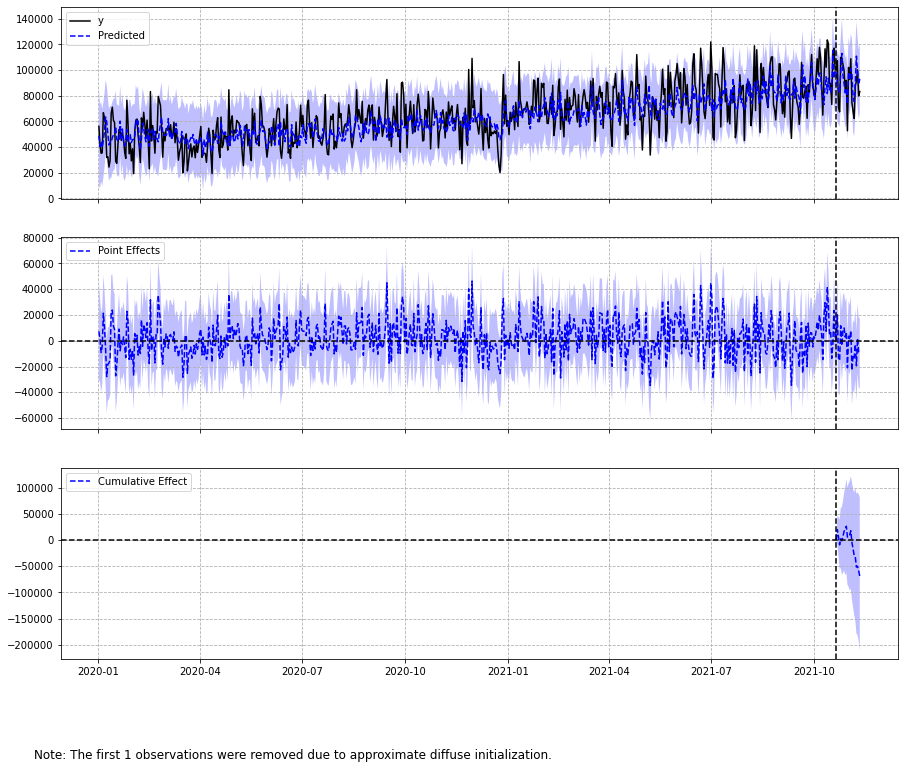

In [74]:
time_lvl = 'dt'
metric = 'gmv_w_cancel_est'

pre_period = ['2020-01-01', '2021-10-21']
post_period = ['2021-10-22', '2021-11-11']

data = ts_bath.groupby([time_lvl, 'bath'])[metric].sum().reset_index().pivot(time_lvl, 'bath', metric)
data = data[['vanities', 'other bath']]

ci = CausalImpact(data, pre_period, post_period)
print(ci.summary())
ci.plot()

## Daily CM (Insig. down by 12%)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    2816.99            59156.82
Prediction (s.d.)         3185.53 (697.02)   66896.22 (14637.33)
95% CI                    [1859.49, 4591.74] [39049.3, 96426.59]

Absolute effect (s.d.)    -368.54 (697.02)   -7739.39 (14637.33)
95% CI                    [-1774.75, 957.5]  [-37269.77, 20107.52]

Relative effect (s.d.)    -11.57% (21.88%)   -11.57% (21.88%)
95% CI                    [-55.71%, 30.06%]  [-55.71%, 30.06%]

Posterior tail-area probability p: 0.29
Posterior prob. of a causal effect: 71.33%

For more details run the command: print(impact.summary('report'))


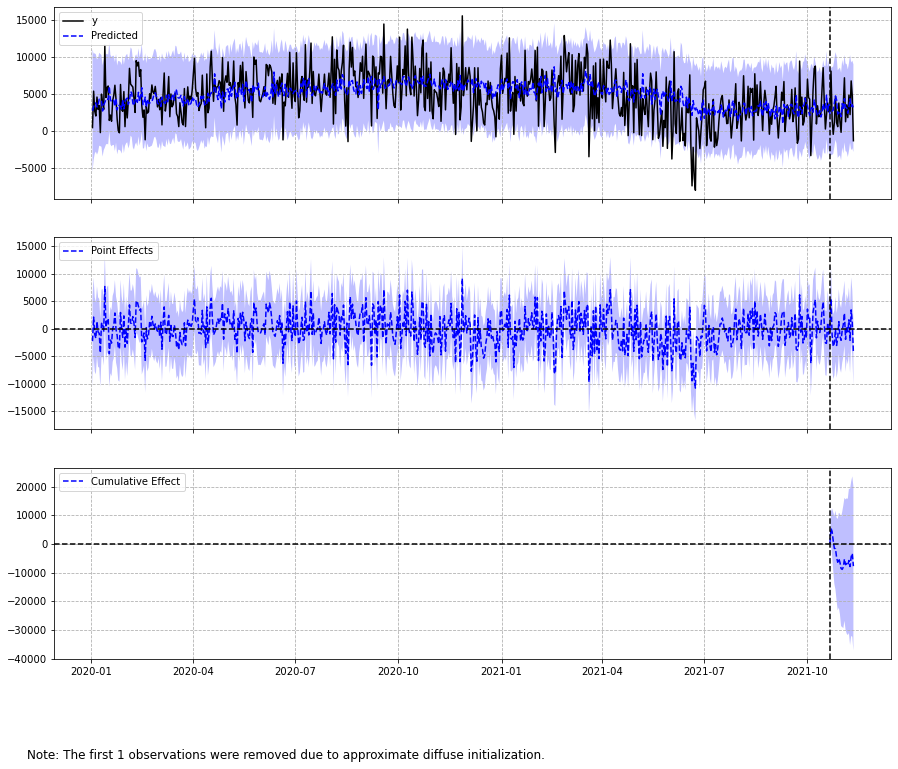

In [75]:
time_lvl = 'dt'
metric = 'cm'

pre_period = ['2020-01-01', '2021-10-21']
post_period = ['2021-10-22', '2021-11-11']

data = ts_bath.groupby([time_lvl, 'bath'])[metric].sum().reset_index().pivot(time_lvl, 'bath', metric)
data = data[['vanities', 'other bath']]

ci = CausalImpact(data, pre_period, post_period)
print(ci.summary())
ci.plot()

## Weekly GMV (sig. down by 9%)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    567588.53          1702765.58
Prediction (s.d.)         622562.47 (33415.83)1867687.4 (100247.49)
95% CI                    [559328.87, 690316.52][1677986.61, 2070949.56]

Absolute effect (s.d.)    -54973.94 (33415.83)-164921.81 (100247.49)
95% CI                    [-122727.99, 8259.66][-368183.98, 24778.97]

Relative effect (s.d.)    -8.83% (5.37%)     -8.83% (5.37%)
95% CI                    [-19.71%, 1.33%]   [-19.71%, 1.33%]

Posterior tail-area probability p: 0.05
Posterior prob. of a causal effect: 94.71%

For more details run the command: print(impact.summary('report'))


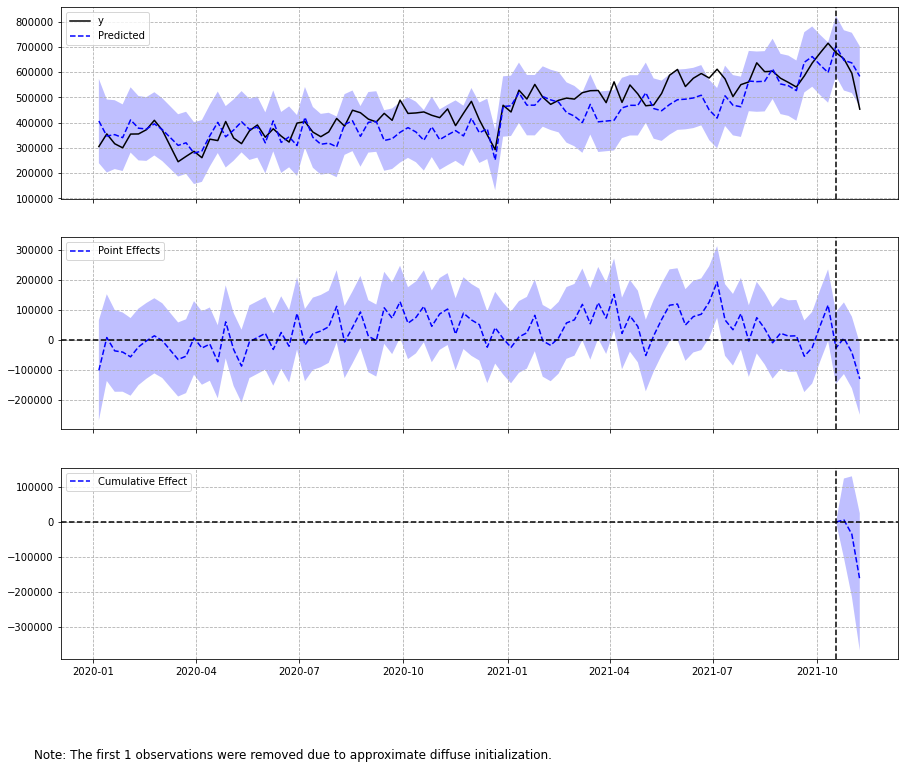

In [80]:

pre_period = ['2019-12-30', '2021-10-18']
post_period = ['2021-10-25', '2021-11-08']

time_lvl = 'week_start'
metric = 'gmv_w_cancel_est'

data = ts_bath.groupby([time_lvl, 'bath'])[metric].sum().reset_index().pivot(time_lvl, 'bath', metric)
data = data[['vanities', 'other bath']]

ci = CausalImpact(data, pre_period, post_period)
print(ci.summary())
ci.plot()


## Weekly CM (Close to sig. down by 33.5%)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    16771.9            50315.71
Prediction (s.d.)         25214.71 (5784.27) 75644.14 (17352.82)
95% CI                    [14084.4, 36758.33][42253.19, 110275.0]

Absolute effect (s.d.)    -8442.81 (5784.27) -25328.43 (17352.82)
95% CI                    [-19986.43, 2687.51][-59959.28, 8062.53]

Relative effect (s.d.)    -33.48% (22.94%)   -33.48% (22.94%)
95% CI                    [-79.26%, 10.66%]  [-79.26%, 10.66%]

Posterior tail-area probability p: 0.08
Posterior prob. of a causal effect: 91.71%

For more details run the command: print(impact.summary('report'))


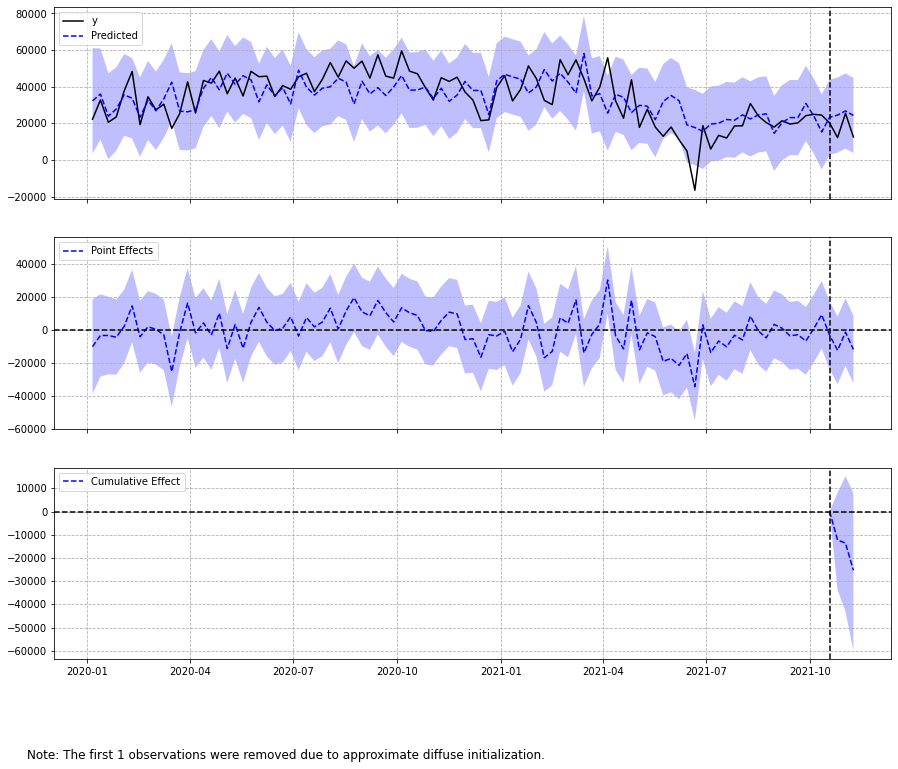

In [81]:

pre_period = ['2019-12-30', '2021-10-18']
post_period = ['2021-10-25', '2021-11-08']

time_lvl = 'week_start'
metric = 'cm'

data = ts_bath.groupby([time_lvl, 'bath'])[metric].sum().reset_index().pivot(time_lvl, 'bath', metric)
data = data[['vanities', 'other bath']]

ci = CausalImpact(data, pre_period, post_period)
print(ci.summary())
ci.plot()


## Monthly GMV (close to sig. up by 28%)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1183238.55         2366477.11
Prediction (s.d.)         919693.26 (164140.83)1839386.52 (328281.66)
95% CI                    [587154.13, 1230574.36][1174308.26, 2461148.72]

Absolute effect (s.d.)    263545.3 (164140.83)527090.59 (328281.66)
95% CI                    [-47335.81, 596084.42][-94671.61, 1192168.84]

Relative effect (s.d.)    28.66% (17.85%)    28.66% (17.85%)
95% CI                    [-5.15%, 64.81%]   [-5.15%, 64.81%]

Posterior tail-area probability p: 0.05
Posterior prob. of a causal effect: 94.61%

For more details run the command: print(impact.summary('report'))


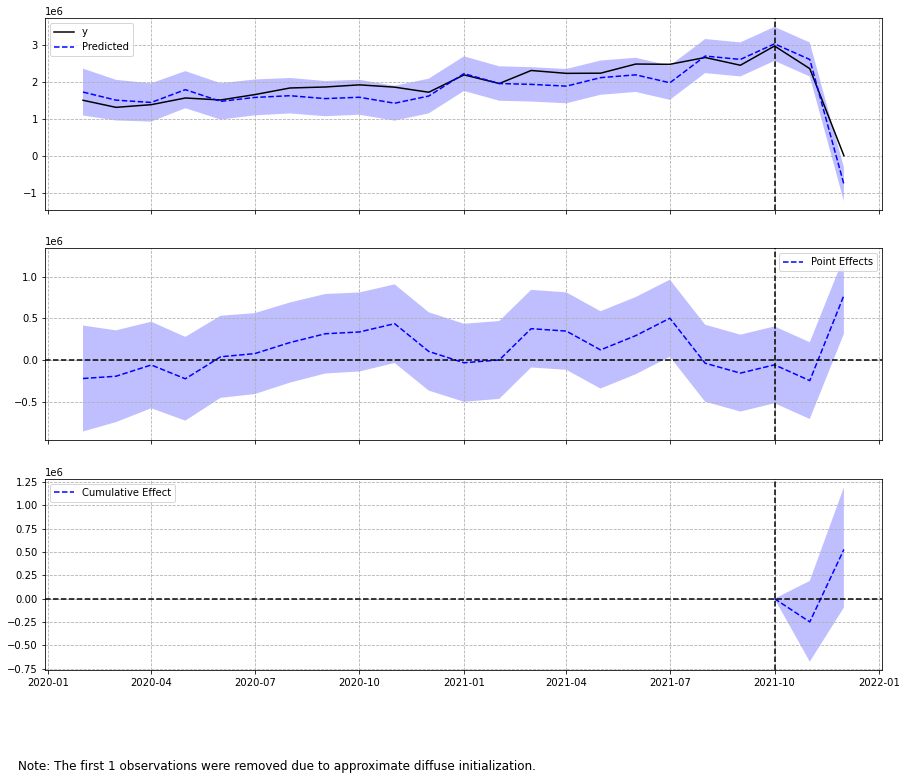

In [82]:
pre_period = ['2020-01-01', '2021-10-01']
post_period = ['2021-11-01', '2021-12-01']

time_lvl = 'month'
metric = 'gmv_w_cancel_est'

data = ts_bath.groupby([time_lvl, 'bath'])[metric].sum().reset_index().pivot(time_lvl, 'bath', metric)
data = data[['vanities', 'other bath']]

ci = CausalImpact(data, pre_period, post_period)
print(ci.summary())
ci.plot()

## Monthly CM (close to sig. up y 200%)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    47041.94           94083.89
Prediction (s.d.)         12567.5 (21731.92) 25135.01 (43463.84)
95% CI                    [-31314.57, 53872.98][-62629.14, 107745.97]

Absolute effect (s.d.)    34474.44 (21731.92)68948.88 (43463.84)
95% CI                    [-6831.04, 78356.51][-13662.08, 156713.03]

Relative effect (s.d.)    274.31% (172.92%)  274.31% (172.92%)
95% CI                    [-54.35%, 623.49%] [-54.35%, 623.49%]

Posterior tail-area probability p: 0.05
Posterior prob. of a causal effect: 94.71%

For more details run the command: print(impact.summary('report'))


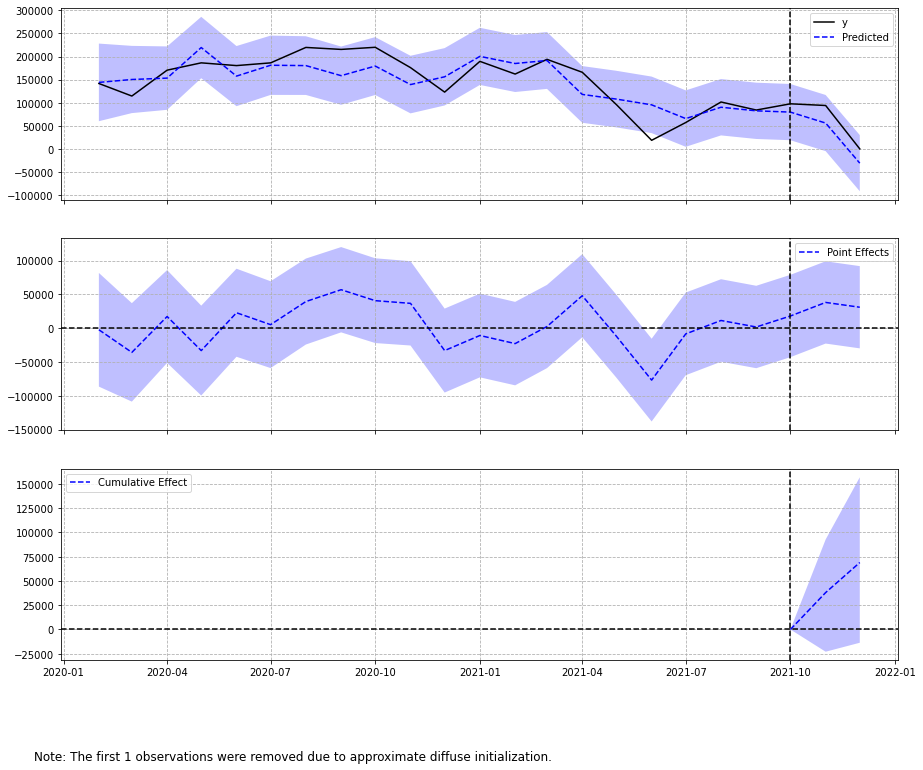

In [83]:
pre_period = ['2020-01-01', '2021-10-01']
post_period = ['2021-11-01', '2021-12-01']

time_lvl = 'month'
metric = 'cm'

data = ts_bath.groupby([time_lvl, 'bath'])[metric].sum().reset_index().pivot(time_lvl, 'bath', metric)
data = data[['vanities', 'other bath']]

ci = CausalImpact(data, pre_period, post_period)
print(ci.summary())
ci.plot()

# Dining tables

In [87]:
# filter for bath products and exclude T1
ts_dining = ts.query('leaf_category == "dining tables" or leaf_category == "dining chairs"') 
# ts_dining = ts_dining.assign(bath = np.where(ts_dining['leaf_category']=='bathroom vanities and sink consoles', 'vanities', 'other bath'))
ts_dining

,dt,ramp,l1,l2,l3,l4,leaf_category,gmv_w_cancel_est,spend,cm,year,month,week,week_start
3581,2020-09-06,T2,furniture,kitchen and dining furniture,dining chairs,Unmapped,dining chairs,17336.42,-528.679800,1205.140156,2020,2020-09-01,2020-08-31/2020-09-06,2020-08-31
3582,2021-01-23,C2,furniture,kitchen and dining furniture,dining tables,Unmapped,dining tables,2578.00,-378.970387,-1030.309306,2021,2021-01-01,2021-01-18/2021-01-24,2021-01-18
3590,2021-01-31,T2,furniture,kitchen and dining furniture,dining chairs,Unmapped,dining chairs,13791.00,-800.847622,2029.377631,2021,2021-01-01,2021-01-25/2021-01-31,2021-01-25
3603,2020-03-26,C2,furniture,kitchen and dining furniture,dining tables,Unmapped,dining tables,11954.04,-423.244738,147.167332,2020,2020-03-01,2020-03-23/2020-03-29,2020-03-23
3605,2020-03-25,C2,furniture,kitchen and dining furniture,dining tables,Unmapped,dining tables,8747.78,-433.600647,1170.690489,2020,2020-03-01,2020-03-23/2020-03-29,2020-03-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224165,2021-04-23,C2,furniture,kitchen and dining furniture,dining tables,outdoor dining tables,dining tables,0.00,-1.060000,-1.060000,2021,2021-04-01,2021-04-19/2021-04-25,2021-04-19
224170,2020-10-20,T2,furniture,kitchen and dining furniture,dining chairs,armchairs and accent chairs,dining chairs,0.00,-1.250000,-1.250000,2020,2020-10-01,2020-10-19/2020-10-25,2020-10-19
224218,2021-09-09,T2,furniture,kitchen and dining furniture,dining chairs,sofas,dining chairs,0.00,-0.730000,-0.730000,2021,2021-09-01,2021-09-06/2021-09-12,2021-09-06
224285,2021-06-16,C2,furniture,kitchen and dining furniture,dining tables,coffee tables,dining tables,0.00,-5.430000,-5.430000,2021,2021-06-01,2021-06-14/2021-06-20,2021-06-14


## Daily GMV (Sig down by 23%)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    11933.93           167075.01
Prediction (s.d.)         15447.49 (1294.59) 216264.85 (18124.23)
95% CI                    [12909.76, 17984.45][180736.58, 251782.26]

Absolute effect (s.d.)    -3513.56 (1294.59) -49189.84 (18124.23)
95% CI                    [-6050.52, -975.83][-84707.26, -13661.57]

Relative effect (s.d.)    -22.75% (8.38%)    -22.75% (8.38%)
95% CI                    [-39.17%, -6.32%]  [-39.17%, -6.32%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 99.6%

For more details run the command: print(impact.summary('report'))


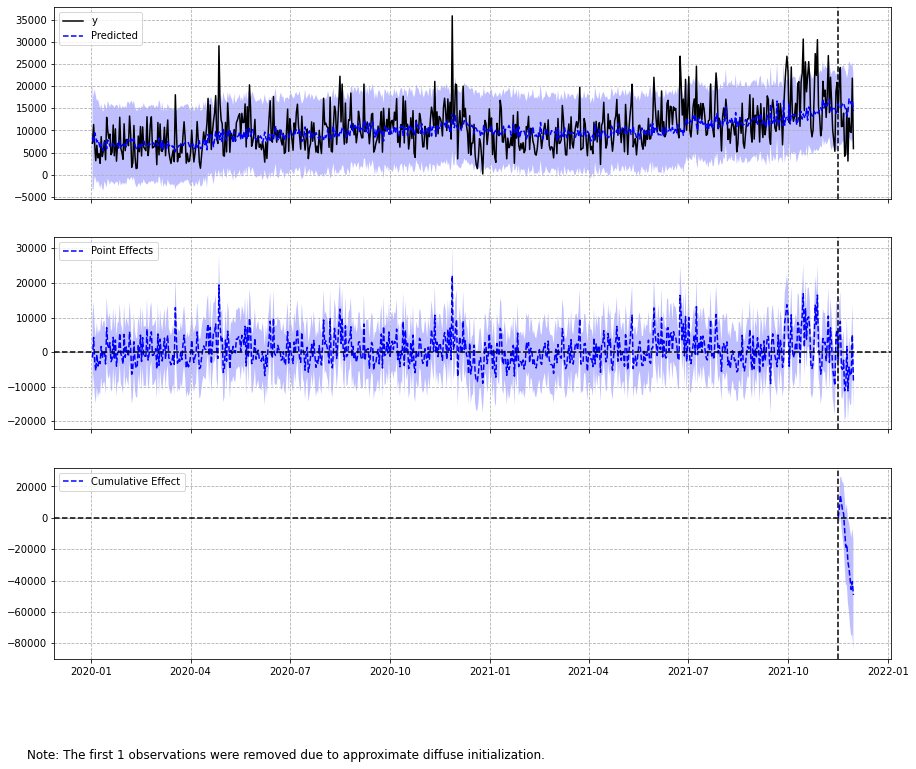

In [90]:
time_lvl = 'dt'
metric = 'gmv_w_cancel_est'

pre_period = ['2020-01-01', '2021-11-16']
post_period = ['2021-11-17', '2021-11-30']

data = ts_dining.groupby([time_lvl, 'l3'])[metric].sum().reset_index().pivot(time_lvl, 'l3', metric)
data = data[['dining tables', 'dining chairs']]

ci = CausalImpact(data, pre_period, post_period)
print(ci.summary())
ci.plot()

## Daily CM (Insig. down by )

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    72.89              1020.45
Prediction (s.d.)         -31.54 (410.8)     -441.62 (5751.16)
95% CI                    [-824.89, 785.4]   [-11548.5, 10995.65]

Absolute effect (s.d.)    104.43 (410.8)     1462.07 (5751.16)
95% CI                    [-712.51, 897.78]  [-9975.19, 12568.95]

Relative effect (s.d.)    -331.07% (1302.29%)-331.07% (1302.29%)
95% CI                    [-2846.11%, 2258.78%][-2846.11%, 2258.78%]

Posterior tail-area probability p: 0.38
Posterior prob. of a causal effect: 61.64%

For more details run the command: print(impact.summary('report'))


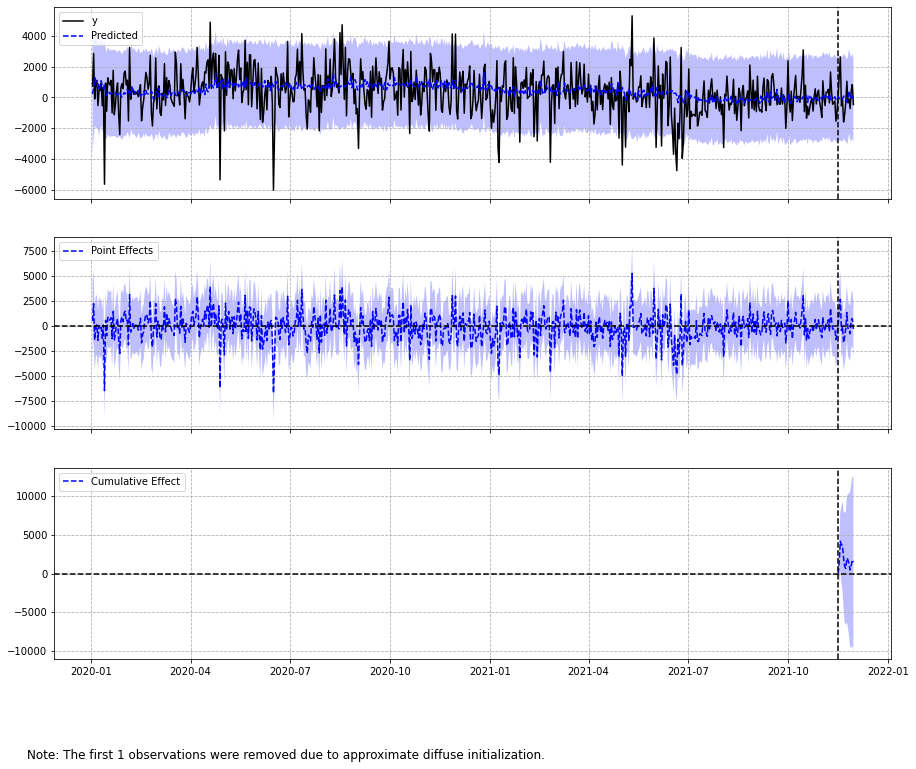

In [92]:
time_lvl = 'dt'
metric = 'cm'

pre_period = ['2020-01-01', '2021-11-16']
post_period = ['2021-11-17', '2021-11-30']

data = ts_dining.groupby([time_lvl, 'l3'])[metric].sum().reset_index().pivot(time_lvl, 'l3', metric)
data = data[['dining tables', 'dining chairs']]

ci = CausalImpact(data, pre_period, post_period)
print(ci.summary())
ci.plot()

In [96]:
data.loc[data.index<'2021-11-17'].index.min(), \
data.loc[data.index<'2021-11-17'].index.max(), \
data.loc[data.index>='2021-11-17'].index.min(), \
data.loc[(data.index>='2021-11-17') ].index.max()

(Timestamp('2019-12-30 00:00:00'),
 Timestamp('2021-11-15 00:00:00'),
 Timestamp('2021-11-22 00:00:00'),
 Timestamp('2021-11-29 00:00:00'))

## Weekly GMV (Sign down by 37%)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    43329.28           86658.56
Prediction (s.d.)         68318.46 (10819.72)136636.92 (21639.44)
95% CI                    [46496.27, 88908.78][92992.53, 177817.57]

Absolute effect (s.d.)    -24989.18 (10819.72)-49978.36 (21639.44)
95% CI                    [-45579.5, -3166.99][-91159.01, -6333.97]

Relative effect (s.d.)    -36.58% (15.84%)   -36.58% (15.84%)
95% CI                    [-66.72%, -4.64%]  [-66.72%, -4.64%]

Posterior tail-area probability p: 0.01
Posterior prob. of a causal effect: 98.7%

For more details run the command: print(impact.summary('report'))


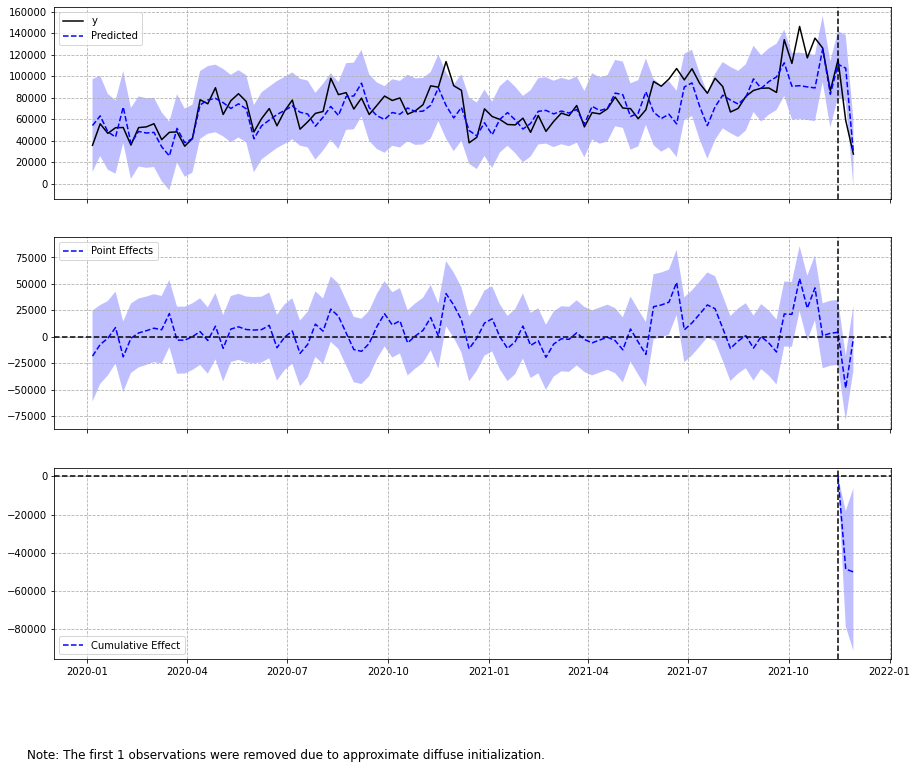

In [97]:
time_lvl = 'week_start'
metric = 'gmv_w_cancel_est'

pre_period = ['2019-12-30', '2021-11-15']
post_period = ['2021-11-22', '2021-11-29']

data = ts_dining.groupby([time_lvl, 'l3'])[metric].sum().reset_index().pivot(time_lvl, 'l3', metric)
data = data[['dining tables', 'dining chairs']]

ci = CausalImpact(data, pre_period, post_period)
print(ci.summary())
ci.plot()

## Weekly CM (Insig. down by 140%)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    -361.46            -722.91
Prediction (s.d.)         927.51 (3584.1)    1855.02 (7168.2)
95% CI                    [-6058.8, 7990.62] [-12117.6, 15981.24]

Absolute effect (s.d.)    -1288.97 (3584.1)  -2577.93 (7168.2)
95% CI                    [-8352.07, 5697.34][-16704.15, 11394.68]

Relative effect (s.d.)    -138.97% (386.42%) -138.97% (386.42%)
95% CI                    [-900.48%, 614.26%][-900.48%, 614.26%]

Posterior tail-area probability p: 0.33
Posterior prob. of a causal effect: 66.73%

For more details run the command: print(impact.summary('report'))


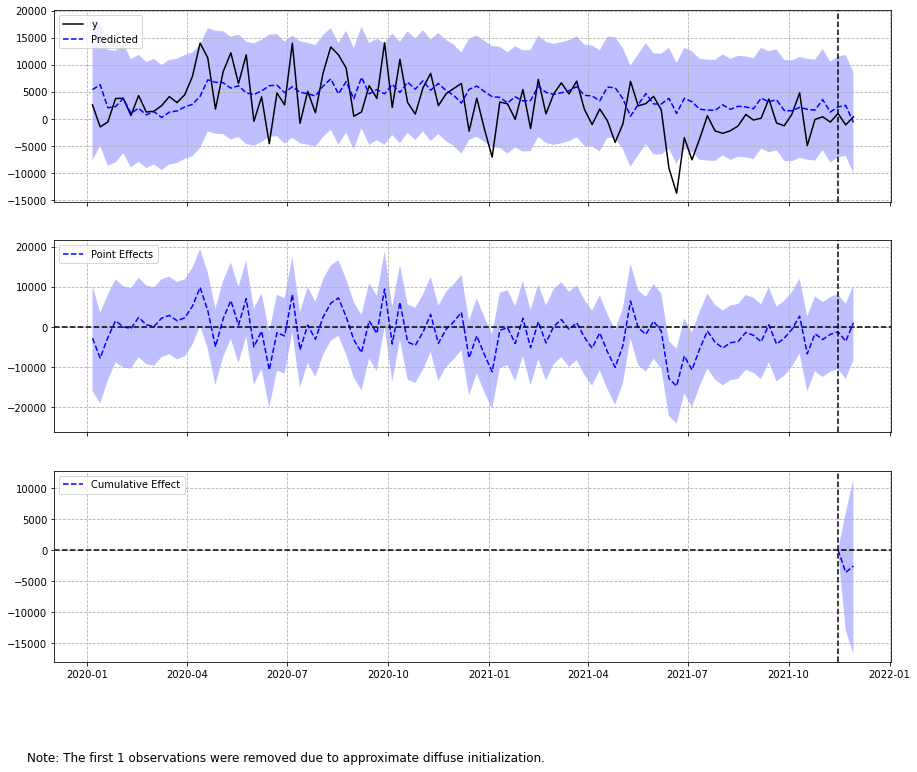

In [98]:
time_lvl = 'week_start'
metric = 'cm'

pre_period = ['2019-12-30', '2021-11-15']
post_period = ['2021-11-22', '2021-11-29']

data = ts_dining.groupby([time_lvl, 'l3'])[metric].sum().reset_index().pivot(time_lvl, 'l3', metric)
data = data[['dining tables', 'dining chairs']]

ci = CausalImpact(data, pre_period, post_period)
print(ci.summary())
ci.plot()